In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import tiktoken
import torch
from transformers import GPT2LMHeadModel, pipeline

In [3]:
# check if NVIDIA drivers are installed
!nvidia-smi

Sun Jun 15 21:32:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:38:00.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# ensure CUDA toolkit and cuDNN are installed
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [5]:
# check if PyTorch is installed with CUDA support
print('Pytorch version:', torch.__version__)
print('Pytorch CUDA version:', torch.version.cuda)

Pytorch version: 2.6.0+cu124
Pytorch CUDA version: 12.4


In [6]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('CUDA available:', torch.cuda.is_available())
print('CUDA device count:', torch.cuda.device_count())
print('CUDA device name:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A')
print(f'--> Using device: {device}')

CUDA available: True
CUDA device count: 4
CUDA device name: NVIDIA L4
--> Using device: cuda


# 1. Exploring the GPT-2 (124M) OpenAI checkpoint

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')
sd_hf = model_hf.state_dict()

In [4]:
params = list(sd_hf.items())

print('Token embeddings: ', params[0][0], '-->', params[0][1].shape)
print('Positional embeddings: ', params[1][0], '-->', params[1][1].shape)
print('First attention head:')

for i in range(12):
    print('  ', params[2 + i][0], '-->', params[2 + i][1].shape)

print('Final language modeling head:', params[-1][0], '-->', params[-1][1].shape)

Token embeddings:  transformer.wte.weight --> torch.Size([50257, 768])
Positional embeddings:  transformer.wpe.weight --> torch.Size([1024, 768])
First attention head:
   transformer.h.0.ln_1.weight --> torch.Size([768])
   transformer.h.0.ln_1.bias --> torch.Size([768])
   transformer.h.0.attn.c_attn.weight --> torch.Size([768, 2304])
   transformer.h.0.attn.c_attn.bias --> torch.Size([2304])
   transformer.h.0.attn.c_proj.weight --> torch.Size([768, 768])
   transformer.h.0.attn.c_proj.bias --> torch.Size([768])
   transformer.h.0.ln_2.weight --> torch.Size([768])
   transformer.h.0.ln_2.bias --> torch.Size([768])
   transformer.h.0.mlp.c_fc.weight --> torch.Size([768, 3072])
   transformer.h.0.mlp.c_fc.bias --> torch.Size([3072])
   transformer.h.0.mlp.c_proj.weight --> torch.Size([3072, 768])
   transformer.h.0.mlp.c_proj.bias --> torch.Size([768])
Final language modeling head: lm_head.weight --> torch.Size([50257, 768])


In [5]:
print('Visualizing the first 20 values of the positional embeddings:')
sd_hf['transformer.wpe.weight'].view(-1)[:20]

Visualizing the first 20 values of the positional embeddings:


tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

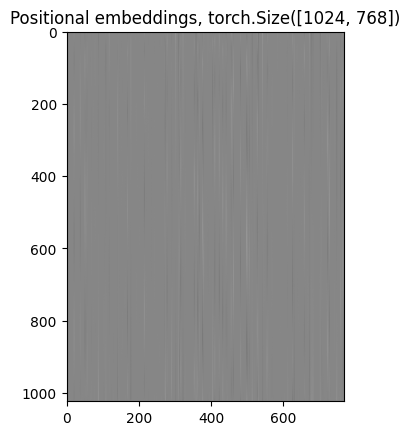

In [6]:
plt.title(f'Positional embeddings, {params[1][1].shape}')
plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray');

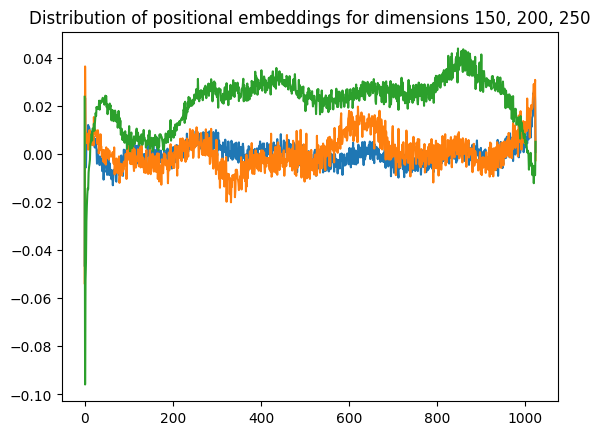

In [7]:
plt.title('Distribution of positional embeddings for dimensions 150, 200, 250')
plt.plot(sd_hf['transformer.wpe.weight'][:, 150]);
plt.plot(sd_hf['transformer.wpe.weight'][:, 200]);
plt.plot(sd_hf['transformer.wpe.weight'][:, 250]);

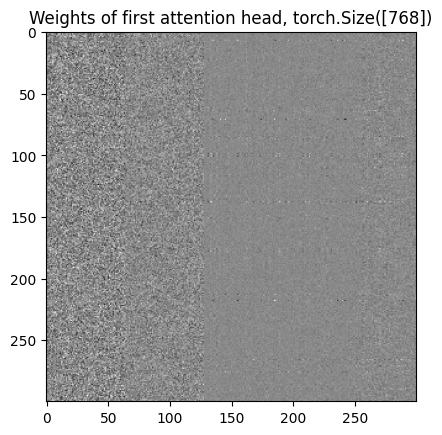

In [8]:
plt.title(f'Weights of first attention head, {params[2][1].shape}')
plt.imshow(sd_hf['transformer.h.1.attn.c_attn.weight'][:300, :300], cmap='gray');

In [9]:
generator = pipeline('text-generation', model=model_hf, tokenizer='gpt2')
generator('Once upon a time', truncation=True, max_length=50, num_return_sequences=5)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'Once upon a time, it seemed as though the world would be made of glass.\n\nIt would be as if the Earth was in motion.\n\nAnd on that day, when the world seemed to be in motion, the world would be filled with wonder, and the world would be filled with hope.\n\nIt was that day, and it would be that day.\n\nThe world would be filled with the light of the sun.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nThe world would be filled with the light of the moon.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nThe world would be filled with the light of the stars.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n\nIt was that day, and it would be that day.\n'},
 {'generated_text': 'Once upon a time he

# 2. Dataset

The dataset used in this section is the [TinyShakespear](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) dataset, which is a collection of text similar to the works of William Shakespeare. The dataset is small enough to fit in memory and is used to demonstrate the training process of the GPT-2 model.

In [10]:
with open('../data/tiny_shakespear.txt', 'r') as f:
    text = f.read()

print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [11]:
encodings = tiktoken.get_encoding('gpt2')
char_count = len(text)
tokens = encodings.encode(text)
print('Number of words:', char_count)
print('Number of tokens:', len(tokens))
print('Compression ratio:', round(len(tokens) / char_count, 3))

Number of words: 1115393
Number of tokens: 338024
Compression ratio: 0.303


In [12]:
data = text[:1000]
data

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

### 2.1. Converting token sequence into batches

In [13]:
context_length = 1024
buffer = torch.tensor(tokens)
num_batches = buffer.shape[0] // context_length

input_buffer = buffer[:num_batches * context_length]
inputs = input_buffer.view(num_batches, context_length)

target_buffer = buffer[1:num_batches * context_length + 1]
targets = target_buffer.view(num_batches, context_length)

print(f'Inputs: shape={inputs.shape}, dtype={inputs.dtype}, device={inputs.device}')
print(f'Targets: shape={targets.shape}, dtype={targets.dtype}, device={targets.device}')
print(f'First input sequence: {inputs[0][:10]}...')
print(f'First target sequence: {targets[0][:10]}...')

Inputs: shape=torch.Size([330, 1024]), dtype=torch.int64, device=cpu
Targets: shape=torch.Size([330, 1024]), dtype=torch.int64, device=cpu
First input sequence: tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11])...
First target sequence: tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285])...


# 3. Implementing the model

The code for this section is in the `gpt2.py` file. Below are a few important notes about the implementation.

GPT-2 implements a modified version of the Transformer model introduced in the paper "Attention is All You Need" by Vaswani et al. (2017). In particular, it does not have the encoder part of the Transformer model, only the decoder part. The decoder part of the Transformer model is composed of a stack of N=12 identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a position-wise fully connected feed-forward network.

There are other two important differences, described in section 2.3 of the GPT-2 paper:
> "Layer normalization was moved to the input of each sub-block, similar to a pre-activation residual network, and an additional layer normalization was added after the final self-attention block."

An important consequence of moving the layer normalization to the input of each sub-block is that the normalization is now applied outside of the residual stream. This difference makes the residual stream more stable during training.

<div align="center">
  <img src="../assets/transformer.jpg" width="300"/>
</div>

### 3.1. Activation function

The activation function used in the feed-forward network is the GELU (*Gaussian Error Linear Units*) function. The GELU function is a smoothed approximation of the rectifier linear unit (ReLU) function and, as implemented in pyTorch, it has two versions:
- the original version, which is the Cumulative Distribution Function (CDF) of the Gaussian distribution
- the `tanh` approximation version, which is faster to compute

<div align="center">
  <img src="../assets/gelu.jpg" width="400"/>
</div>

### 3.2. Parameter sharing: token embeddings and output layer

In the "Attention is All You Need" paper, the authors propose to share parameters between the input and output layers of a neural network:

> In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [30].

The reference used above refer to the paper "Using the Output Embedding to Improve Language Models" by Mnih and Teh (2012). In this paper, the authors propose using the same embedding matrix for both the input and output layers, which reduces the number of parameters in the model and improves generalization:

> We call $U$ the input embedding, and $V$ the output embedding. In both matrices, we expect rows that correspond to similar words to be similar: for the input embedding, we would like the network to react similarly to synonyms, while in the output embedding, we would like the scores of words that are interchangeable to be similar.

In [14]:
print(sd_hf['lm_head.weight'].shape)
print(sd_hf['transformer.wte.weight'].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [15]:
(sd_hf['lm_head.weight'] == sd_hf['transformer.wte.weight']).all()

tensor(True)

In [16]:
print(sd_hf['lm_head.weight'].data_ptr())
print(sd_hf['transformer.wte.weight'].data_ptr())

139996667228115
139996667228115


### 3.3. Weight initialization

In the [code]((https://github.com/openai/gpt-2/blob/master/src/model.py)) released by OpenAI, the weights are initialized with a standard deviation of 0.02 and the biases are initialized to zero.

```python
def conv1d(x, scope, nf, *, w_init_stdev=0.02):
    with tf.variable_scope(scope):
        ...
        w = tf.get_variable('w', [1, nx, nf], 
                           initializer=tf.random_normal_initializer(stddev=w_init_stdev))
        b = tf.get_variable('b', [nf], 
                           initializer=tf.constant_initializer(0))
        ...
```

By its turn, the token embeddings are also initialized with a standard deviation of 0.02, while the positional embeddings are initialized to 0.01:

```python
def model(hparams, X, past=None, scope='model', reuse=False):
    with tf.variable_scope(scope, reuse=reuse):
        ...
        wpe = tf.get_variable('wpe', [hparams.n_ctx, hparams.n_embd],
                             initializer=tf.random_normal_initializer(stddev=0.01))
        wte = tf.get_variable('wte', [hparams.n_vocab, hparams.n_embd],
                             initializer=tf.random_normal_initializer(stddev=0.02))
        ...
```

Finally, according to the [GPT-2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf):

> A modified initialization which accounts for the accumulation on the residual path with model depth is used. We scale the weights of residual layers at initialization by a factor of $\frac{1}{\sqrt(N)}$ where $N$ is the number of
residual layers.

In [17]:
# standard deviation grows inside the residual stream

x = torch.zeros(768)          # embedding dimension
n = 100                       # number of layers

for i in range(n):
    x += torch.randn(768)     # add output of attention heads to residual stream

print(f'Final standard deviation after {n} layers: {x.std().item()}')

Final standard deviation after 100 layers: 9.821331024169922


In [18]:
# standard deviation remains stable when scaled by -sqrt(1/n)

x = torch.zeros(768)                      # embedding dimension
n = 100                                   # number of layers

for i in range(n):
    x += n ** -0.5 * torch.randn(768)     # add output of attention heads to residual stream

print(f'Final standard deviation after {n} layers: {x.std().item()}')

Final standard deviation after 100 layers: 0.979456901550293


### 3.4. Flash attention

Flash attention is a memory-efficient attention mechanism that reduces the memory footprint of the attention computation. I will not go into details here, but it is worth looking at.

# Sources

1. [Ground truth - Let's build GPT-2 (124M), by Andrej Karpathy](https://www.youtube.com/watch?v=l8pRSuU81PU&t)
2. [Ground repository - OpenAI GPT-2](https://github.com/openai/gpt-2)
3. [Language models are unsupervised multitask learners [GPT-2 paper], by Alec Radford; Dario Amodei; Ilya Sutskever; et al.](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
4. [Language Models are Few-Shot Learners [GPT-3 paper, by Alec Radford; Dario Amodei; Ilya Sutskever; et al.]](https://arxiv.org/pdf/2005.14165)
5. [Gaussian Error Linear Units (GELUs), by Hendrycks, D.; et al.](https://arxiv.org/pdf/1606.08415)
6. [Attention is all you need, by A. Vaswani, et. al.](https://arxiv.org/pdf/1706.03762)
7. [Using the Output Embedding to Improve Language Models, by Press and Wolf](https://arxiv.org/pdf/1608.05859)
8. [FlashAttention: Fast and Memory-Eﬃcient Exact Attention with IO-Awareness, by Dao, et. al.](https://arxiv.org/pdf/2205.14135)